# Time Series Forcasting

### Timothy Helton

Tutorial from Dr. Jason Brownlee's [Machine Learning Mastery](http://machinelearningmastery.com/simple-time-series-forecasting-models/) site.

---

---
### Imports

In [1]:
from collections import OrderedDict
import os
import os.path as osp

from dateutil.parser import parse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

---

---
### Load Data

In [2]:
data_file = osp.join('..', 'data', 'time_series_forecasting',
                     'car_sales.csv')
data = pd.read_csv(data_file, header=0)
data.drop(108, inplace=True)
data.columns = ['date', 'sales']
data.date = data.date.map(lambda x: parse(f'{x}-01'))

In [3]:
data.head()
data.tail()

,date,sales
0,1960-01-01,6550.0
1,1960-02-01,8728.0
2,1960-03-01,12026.0
3,1960-04-01,14395.0
4,1960-05-01,14587.0


,date,sales
103,1968-08-01,16722.0
104,1968-09-01,14385.0
105,1968-10-01,21342.0
106,1968-11-01,17180.0
107,1968-12-01,14577.0


In [4]:
# TODO is there a better way to do this
months = OrderedDict({
    'JAN': 1,
    'FEB': 2,
    'MAR': 3,
    'APR': 4,
    'MAY': 5,
    'JUN': 6,
    'JUL': 7,
    'AUG': 8,
    'SEP': 9,
    'OCT': 10,
    'NOV': 11,
    'DEC': 12,
})
month_masks = OrderedDict(
    {k: data.date.map(lambda x: x.month == v)
     for k, v in months.items()})

In [10]:
sales = pd.DataFrame(OrderedDict({k: data.sales[v]
                                  for k, v in month_masks.items()}))

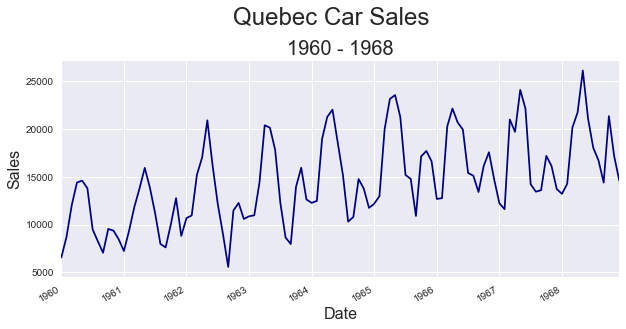

In [5]:
suptitle = 'Quebec Car Sales'
title = '1960 - 1968'

suptitle_size = 24
title_size = 20
label_size = 16

fig = plt.figure(f'{suptitle}: {title}', figsize=(10, 15),
                 facecolor='white', edgecolor='black')
rows, cols = (3, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))

data.plot(x='date', y='sales', color='navy', legend=None, ax=ax1);

ax1.set_title(title, fontsize=title_size)
ax1.set_xlabel('Date', fontsize=label_size)
ax1.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, y=0.93)
fig.autofmt_xdate();

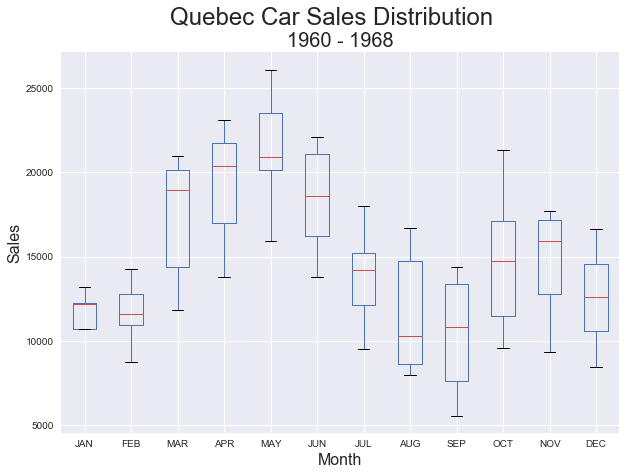

In [6]:
suptitle = 'Quebec Car Sales Distribution'
title = '1960 - 1968'

suptitle_size = 24
title_size = 20
label_size = 16

fig = plt.figure(f'{suptitle}: {title}', figsize=(10, 7),
                 facecolor='white', edgecolor='black')
rows, cols = (1, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))

sales.plot(kind='box', ax=ax1)

ax1.set_title(title, fontsize=title_size)
ax1.set_xlabel('Month', fontsize=label_size)
ax1.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, y=0.97);

---

---
### Optimized Persistence Forcast

#### Establish Train and Test Datasets

In [7]:
train_duration = 24
train = data[0:-train_duration]
test = data[-train_duration:]

#### Derive Persistance Model

- prediction[n] = train[-n]

#### Make Forcast

In [8]:
scores = []
for td in range(train_duration):
    nieve = data.shift(td + 1)
    scores.append(mean_squared_error(test.sales,
                                     nieve.sales[-train_duration:])**0.5)
forcast_score = nieve.date[-train_duration:].copy().to_frame()
forcast_score['scores'] = scores

#### Plot Initial Prediction

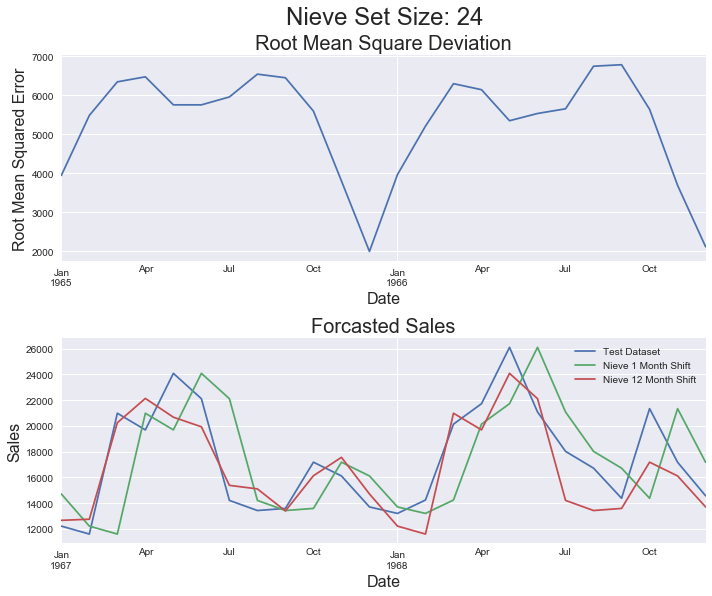

In [64]:
suptitle = f'Nieve Set Size: {train_duration}'
title = 'Root Mean Square Deviation'


suptitle_size = 24
title_size = 20
label_size = 16

fig = plt.figure(f'{suptitle}: {title}', figsize=(10, 8),
                 facecolor='white', edgecolor='black')
rows, cols = (2, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))
ax2 = plt.subplot2grid((rows, cols), (1, 0))

forcast_score.plot(x='date', y='scores', legend=None, ax=ax1)

ax1.set_title(title, fontsize=title_size)
ax1.set_xlabel('Date', fontsize=label_size)
ax1.set_ylabel('Root Mean Squared Error', fontsize=label_size)

test.plot(x='date', y='sales', label='Test Dataset', ax=ax2)

nieve_1 = data.copy()
nieve_1.sales = nieve_1.sales.shift(1)
nieve_1[-train_duration:].plot(x='date', y='sales',
                               label='Nieve 1 Month Shift',
                               ax=ax2)

nieve_12 = data.copy()
nieve_12.sales = nieve_12.sales.shift(12)
nieve_12[-train_duration:].plot(x='date', y='sales',
                                label='Nieve 12 Month Shift',
                                ax=ax2)

ax2.set_title('Forcasted Sales', fontsize=title_size)
ax2.set_xlabel('Date', fontsize=label_size)
ax2.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, x=0.54, y=1.03)
plt.tight_layout();

#### Review and Assess

A cyclic pattern occurs every 12 months.
Alter the persistance model to be the average of all prior months of like kind multiplied by a weighting factor.

$\mu_{mon} * w_i$

In [70]:
sales_mean = sales.mean()
sales_mean.index = range(12)
sales_mean = sales_mean.append([sales_mean] * 8, ignore_index=True)

# TODO Figure Out a Weighting Factor (linear regression of means maybe?)
weighted_month = data.copy()
weighted_month.sales = sales_mean

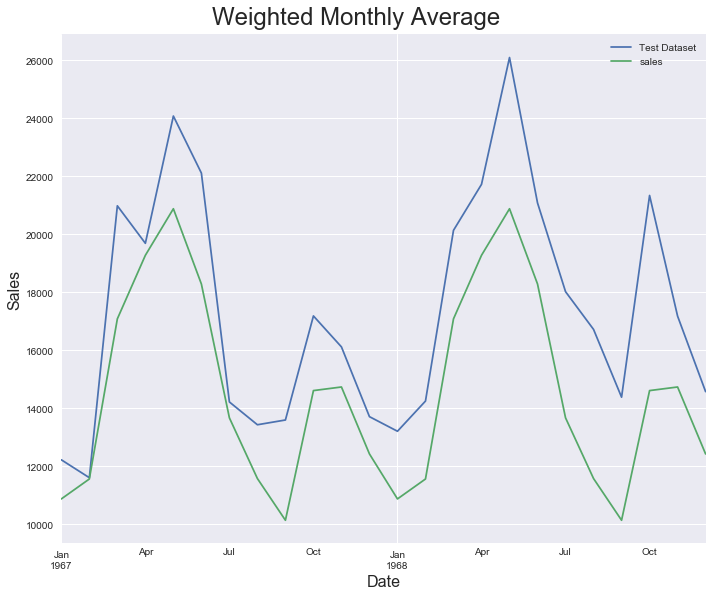

In [69]:
suptitle = 'Weighted Monthly Average'

suptitle_size = 24
label_size = 16

fig = plt.figure(f'{suptitle}', figsize=(10, 8),
                 facecolor='white', edgecolor='black')
rows, cols = (1, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))

test.plot(x='date', y='sales', label='Test Dataset', ax=ax1)
weighted_month[-train_duration:].plot(x='date', y='sales', ax=ax1)

ax1.set_xlabel('Date', fontsize=label_size)
ax1.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, y=1.03)
plt.tight_layout();

---

---
### Expanding Window Forecast

---

---
### Rolling Window Forcast